In [4]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__, keras.__version__)

2.3.1 2.4.0


## Transfer Learning

Assuming we have trained 8 of the 10 classes in the fashion mnist data. The model performs pretty well. Now we need to create a new model which predicts just two classes:

Model A:
"T-shirt/pop", "Trouser", "Pullover", "Dresss", "Coat", "Sandal", "Shirt", "Sneaker"

Model B:
"Bag", "Ankle boot"

we should be able to utilise transfer learning

### Downloading Fashion mnist data

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()


### Data Prep

In [6]:
X_train_A = X_train_full[y_train_full < 8]
y_train_A = y_train_full[y_train_full < 8]

X_test_A = X_test[y_test < 8]
y_test_A = y_test[y_test < 8]


X_train_B = X_train_full[y_train_full >=8]
y_train_B = (y_train_full[y_train_full >=8] == 8).astype(int)


X_test_B = X_test[y_test >=8]
y_test_B = (y_test[y_test >=8] == 8).astype(int)


In [7]:
class_names_A = ["T-shirt/pop", "Trouser", "Pullover", "Dresss", "Coat",
                 "Sandal", "Shirt", "Sneaker"]
class_names_B = ["Bag", "Ankle boot"]

## Build and train Model A 


In this case for simplicity, we will just use a simple sequencial model with dense hidden layers.

In [8]:
NUM_EPOCHS = 20

from tensorflow.keras import activations, layers, initializers, callbacks, models
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, ELU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es_cb = EarlyStopping(patience=3, monitor='val_loss') # early stopping at min loss
md_cb = ModelCheckpoint("f_mnist_model_A.h5", save_best_only=True)

model = Sequential([
        Flatten(input_shape=[28, 28]),
        BatchNormalization(),
        Dense(300, activation = "relu"),
        Dense(300, activation = "relu"),
        Dense(300, activation = "relu"),
        Dense(8, activation = "softmax")
])

model.compile(optimizer = "SGD", loss = "sparse_categorical_crossentropy", metrics = "accuracy")

history = model.fit(X_train_A, y_train_A, epochs=NUM_EPOCHS, validation_split = 0.2, callbacks=[es_cb, md_cb], verbose = True)

Epoch 1/20
1200/1200 [==============================] - 3s 2ms/step - loss: 0.6057 - accuracy: 0.7809 - val_loss: 0.4578 - val_accuracy: 0.8383
Epoch 2/20
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4290 - accuracy: 0.8391 - val_loss: 0.4111 - val_accuracy: 0.8508
Epoch 3/20
1200/1200 [==============================] - 3s 2ms/step - loss: 0.3878 - accuracy: 0.8546 - val_loss: 0.3978 - val_accuracy: 0.8592
Epoch 4/20
1200/1200 [==============================] - 2s 2ms/step - loss: 0.3605 - accuracy: 0.8658 - val_loss: 0.4190 - val_accuracy: 0.8639
Epoch 5/20
1200/1200 [==============================] - 2s 2ms/step - loss: 0.3416 - accuracy: 0.8708 - val_loss: 0.4286 - val_accuracy: 0.8641
Epoch 6/20
1200/1200 [==============================] - 2s 2ms/step - loss: 0.3216 - accuracy: 0.8797 - val_loss: 0.3622 - val_accuracy: 0.8658
Epoch 7/20
1200/1200 [==============================] - 2s 2ms/step - loss: 0.3062 - accuracy: 0.8857 - val_loss: 0.3702 - val_accuracy:

In [9]:
model.evaluate(X_test_A, y_test_A)
model.summary()

250/250 [==============================] - 0s 880us/step - loss: 0.3870 - accuracy: 0.8655
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2408      
Total params: 421,644
Trainab

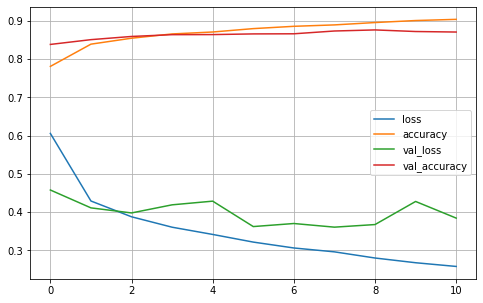

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Transfer Learning with Model B

Remember model B is a binary classifier but the input should be the same. 


In [11]:
from tensorflow.keras import activations, layers, initializers, callbacks, models
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, ELU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_A = tf.keras.models.load_model('f_mnist_model_A.h5')

# we don't want to impact weights of model A. therefore we make a clone. 
# clone model does not copy weights, so we have to set the weights again

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(Dense(1, activation = "sigmoid"))

model_B_on_A.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 301       
Total params: 419,537
Trainable params: 417,969
Non-trainable params: 1,568
____________________________________________

## Freeze layers

As the first few layers will not be initialled randomly, therefore will be large errors. The approach is to freeze the **reused** layers for the first few epoches, giving new layer some time to learn reasonable weights.

In [15]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ['accuracy']) # any freeze/unfreeze requires the model to be recompiled

In [16]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 4, validation_split=0.2)

Epoch 1/4
300/300 [==============================] - 0s 1ms/step - loss: 5.1194e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9992
Epoch 2/4
300/300 [==============================] - 0s 1ms/step - loss: 5.0659e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9992
Epoch 3/4
300/300 [==============================] - 0s 1ms/step - loss: 5.0161e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9992
Epoch 4/4
300/300 [==============================] - 0s 1ms/step - loss: 4.9656e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9992


In [17]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ['accuracy']) # any freeze/unfreeze requires the model to be recompiled

history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 15, validation_split=0.2)

Epoch 1/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0032 - val_accuracy: 0.9987
Epoch 2/15
300/300 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0023 - val_accuracy: 0.9992
Epoch 3/15
300/300 [==============================] - 1s 2ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 4/15
300/300 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 5/15
300/300 [==============================] - 1s 2ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0027 - val_accuracy: 0.9992
Epoch 6/15
300/300 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.0032 - val_accuracy: 0.9987
Epoch 7/15
300/300 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0023 - val_accuracy: 0.9987
Epoch 

In [18]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9975


[0.016677115112543106, 0.9975000023841858]